In [1]:
# import required packages
from fastai.tabular import *

In [2]:
# path to project directory
path = Path('/home/jupyter/fpl-prediction')

In [3]:
# read in training dataset
# created using fpl_data_clean notebook
train_df = pd.read_csv(path/'data/train.csv', index_col=0, dtype={'season':str})

In [4]:
train_df.tail()

,player,gw,position,minutes,team,opponent_team,relative_market_value_team,relative_market_value_opponent_team,was_home,total_points,season,play_proba
69515,Yoshinori_Muto,3,4,2,Newcastle United,Tottenham Hotspur,0.546111,2.117808,False,1,1920,1.0
69516,Youri_Tielemans,3,3,88,Leicester City,Sheffield United,0.848096,0.150592,False,2,1920,1.0
69517,Yves_Bissouma,3,3,0,Brighton and Hove Albion,Southampton,0.448102,0.611235,True,0,1920,0.0
69518,Çaglar_Söyüncü,3,2,90,Leicester City,Sheffield United,0.848096,0.150592,False,5,1920,1.0
69519,Ørjan_Nyland,3,1,0,Aston Villa,Everton,0.340536,1.132957,True,0,1920,1.0


In [5]:
train_df.shape

(69520, 12)

In [6]:
# exclude zero minute rows
#train_df = train_df[train_df['minutes'] != 0].reset_index()

In [7]:
train_df.shape

(69520, 12)

In [8]:
# find validation cut point - index for 18-19 season second half (gw 19)
#valid_start = train_df[(train_df['gw'] > 18) & (train_df['season'] == '1819')].index.min()
# or take validation as same as current prediction set
valid_start = train_df[(train_df['season'] == '1819') & (train_df['gw'] == 4)].index.min()
valid_end = train_df.index.max()

In [9]:
# check data types
train_df.dtypes

player                                  object
gw                                       int64
position                                 int64
minutes                                  int64
team                                    object
opponent_team                           object
relative_market_value_team             float64
relative_market_value_opponent_team    float64
was_home                                  bool
total_points                             int64
season                                  object
play_proba                             float64
dtype: object

In [10]:
# set categorical and continuous variables for tabular learner
cat_vars = ['player', 'gw', 'position', 'team', 'opponent_team', 'was_home', 'season']
cont_vars = ['minutes', 'relative_market_value_team', 'relative_market_value_opponent_team']

In [11]:
# set dependent variable
dep_var = 'total_points'

In [12]:
# set validation dataset based on indexes calculated earlier
valid_idx = range(valid_start, valid_end)

In [13]:
# processors - categorify categorical variables and normalize continuous variables
# fill missing not used because new teams are almost certainly well below the league average
procs=[Categorify, Normalize]

In [14]:
# create databunch
data = (TabularList.from_df(train_df, path=path, cat_names=cat_vars, cont_names=cont_vars, procs=procs,)
                .split_by_idx(valid_idx)
                .label_from_df(cols=dep_var, label_cls=FloatList)
                .databunch())

In [15]:
# set range of predictions - minimum to current max
max_y = np.max(train_df['total_points'])
min_y = np.min(train_df['total_points'])
y_range = torch.tensor([-1, max_y], device=defaults.device)

In [16]:
# instatiate tabular learner
learn = tabular_learner(data, layers=[1000,500], ps=[0.001,0.01], emb_drop=0.04, 
                        y_range=y_range, metrics=rmse)

In [17]:
# take a look at the nueral net architecture
# note that categorical variables all have embeddings (used default embedding sizes)
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(1032, 78)
    (1): Embedding(39, 12)
    (2): Embedding(5, 4)
    (3): Embedding(28, 10)
    (4): Embedding(27, 10)
    (5): Embedding(3, 3)
    (6): Embedding(5, 4)
  )
  (emb_drop): Dropout(p=0.04)
  (bn_cont): BatchNorm1d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=124, out_features=1000, bias=True)
    (1): ReLU(inplace)
    (2): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.001)
    (4): Linear(in_features=1000, out_features=500, bias=True)
    (5): ReLU(inplace)
    (6): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.01)
    (8): Linear(in_features=500, out_features=1, bias=True)
  )
)

In [18]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


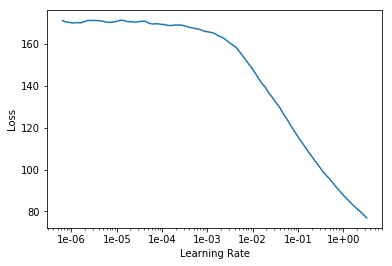

In [19]:
learn.recorder.plot()

In [24]:
# no market value, latest half season validation
learn.fit_one_cycle(3, 1.1e-2, wd=0.2)

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,8.501507,7.926478,2.782442,00:02
1,7.460577,8.293941,2.840935,00:02
2,6.654506,7.472949,2.700373,00:02


In [43]:
# market value, latest half season validation
learn.fit_one_cycle(3, 1.5e-3, wd=0.2)

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,10.148968,8.108212,2.815272,00:02
1,7.744442,7.921211,2.780680,00:02
2,6.750823,7.586754,2.719187,00:02


In [22]:
# no market value, new season validation
learn.fit_one_cycle(4, 1e-2, wd=0.2)

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,8.286838,8.456475,2.861300,00:02
1,7.342739,7.591846,2.721933,00:02
2,7.386149,7.513053,2.702131,00:02
3,6.645412,7.562900,2.718028,00:02


In [20]:
# CURRENT APPROACH
# market value, new season validation
learn.fit_one_cycle(2, 1e-2, wd=0.2)

epoch,train_loss,valid_loss,root_mean_squared_error,time
0,3.950248,3.995664,1.938227,00:06
1,3.197150,3.599984,1.849694,00:05


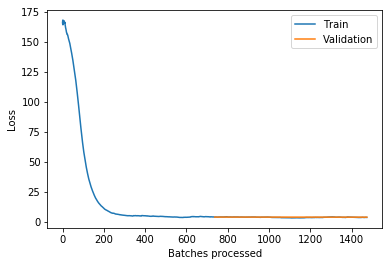

In [20]:
learn.recorder.plot_losses()

In [21]:
# add predictions to the validations set
df_valid = train_df.loc[valid_idx]
df_valid['predicted_points'] = learn.get_preds()[0].data.numpy().T[0]

In [22]:
# look at one team/gameweek
df_valid[(df_valid['team'] == 'Cardiff City') & (df_valid['opponent_team'] == 'Chelsea')].head(10)

,player,gw,position,minutes,team,opponent_team,relative_market_value_team,relative_market_value_opponent_team,was_home,total_points,season,play_proba,predicted_points
48293,Alex_Smithies,5,1,0,Cardiff City,Chelsea,0.18389,2.540586,False,0,1819,NaN,0.113108
48314,Anthony_Pilkington,5,3,0,Cardiff City,Chelsea,0.18389,2.540586,False,0,1819,NaN,0.259166
48318,Aron_Gunnarsson,5,3,0,Cardiff City,Chelsea,0.18389,2.540586,False,0,1819,NaN,0.049991
48321,Ashley Darel Jazz_Richards,5,2,45,Cardiff City,Chelsea,0.18389,2.540586,False,0,1819,NaN,0.824844
48345,Bobby_Reid,5,4,70,Cardiff City,Chelsea,0.18389,2.540586,False,2,1819,NaN,2.176408
48348,Brian_Murphy,5,1,0,Cardiff City,Chelsea,0.18389,2.540586,False,0,1819,NaN,0.044106
48350,Bruno_Ecuele Manga,5,2,90,Cardiff City,Chelsea,0.18389,2.540586,False,0,1819,NaN,1.701848
48354,Callum_Paterson,5,3,19,Cardiff City,Chelsea,0.18389,2.540586,False,1,1819,NaN,0.587257
48394,Danny_Ward_2,5,3,76,Cardiff City,Chelsea,0.18389,2.540586,False,2,1819,NaN,2.109180
48400,David Junior_Hoilett,5,3,90,Cardiff City,Chelsea,0.18389,2.540586,False,2,1819,NaN,2.266871


In [23]:
# look at top predictions
df_valid.sort_values('predicted_points', ascending=False).head(20)

,player,gw,position,minutes,team,opponent_team,relative_market_value_team,relative_market_value_opponent_team,was_home,total_points,season,play_proba,predicted_points
51349,Mohamed_Salah,10,3,90,Liverpool,Cardiff City,2.177887,0.183890,True,15,1819,NaN,8.576435
66509,Mohamed_Salah,36,3,90,Liverpool,Huddersfield Town,2.177887,0.273778,True,19,1819,NaN,8.570484
49177,Mohamed_Salah,6,3,90,Liverpool,Southampton,2.177887,0.654624,True,8,1819,NaN,8.447304
52450,Mohamed_Salah,12,3,90,Liverpool,Fulham,2.177887,0.405284,True,8,1819,NaN,8.324594
67748,Mohamed_Salah,38,3,90,Liverpool,Wolverhampton Wanderers,2.177887,0.388177,True,3,1819,NaN,8.297017
61572,Mohamed_Salah,28,3,90,Liverpool,Watford,2.177887,0.412301,True,3,1819,NaN,8.273408
68308,Mohamed_Salah,1,3,90,Liverpool,Norwich,2.297572,0.198300,True,12,1920,1.0,8.182650
62786,Mohamed_Salah,30,3,90,Liverpool,Burnley,2.177887,0.449442,True,5,1819,NaN,8.179528
50086,Harry_Kane,8,4,90,Tottenham Hotspur,Cardiff City,1.983109,0.183890,True,1,1819,NaN,8.094500
63593,Gabriel Fernando_de Jesus,32,4,90,Manchester City,Cardiff City,2.540586,0.183890,True,5,1819,NaN,8.072028


In [24]:
np.mean(df_valid.sort_values('predicted_points', ascending=False).head(1000)['predicted_points'])

5.604804039001465

In [25]:
np.mean(df_valid.sort_values('predicted_points', ascending=False).head(1000)['total_points'])

5.379

In [26]:
## now we have decided training approach, need to apply to remainder of season
# read in remaining_season.csv
remaining_season_df = pd.read_csv(path/'data/remaining_season.csv', index_col=0)

In [27]:
remaining_season_df.head(1000)

,gw,team,opponent_team,player,position,price,play_proba,was_home,relative_market_value_team,relative_market_value_opponent_team,season,minutes
0,4,Southampton,Manchester United,Jannik_Vestergaard,2,5.0,1.00,True,0.611235,1.706463,1920,90.0
1,4,Southampton,Manchester United,Ryan_Bertrand,2,5.0,0.75,True,0.611235,1.706463,1920,67.5
2,4,Southampton,Manchester United,Yan_Valery,2,5.0,1.00,True,0.611235,1.706463,1920,90.0
3,4,Southampton,Manchester United,Jan_Bednarek,2,4.5,1.00,True,0.611235,1.706463,1920,90.0
4,4,Southampton,Manchester United,Jack_Stephens,2,4.5,1.00,True,0.611235,1.706463,1920,90.0
5,4,Southampton,Manchester United,Maya_Yoshida,2,4.5,1.00,True,0.611235,1.706463,1920,90.0
6,4,Southampton,Manchester United,Kayne_Ramsay,2,4.0,1.00,True,0.611235,1.706463,1920,90.0
7,4,Southampton,Manchester United,Charlie_Austin,4,6.0,0.00,True,0.611235,1.706463,1920,0.0
8,4,Southampton,Manchester United,Danny_Ings,4,6.0,1.00,True,0.611235,1.706463,1920,90.0
9,4,Southampton,Manchester United,Michael_Obafemi,4,5.0,1.00,True,0.611235,1.706463,1920,90.0


In [28]:
# create new databunch, with remaining season as test set
# and using all available data i.e. no validation
data = (TabularList.from_df(train_df, path=path, cat_names=cat_vars, cont_names=cont_vars, procs=procs,)
                .split_none()
                .label_from_df(cols=dep_var, label_cls=FloatList)
                .add_test(TabularList.from_df(remaining_season_df, path=path, cat_names=cat_vars, cont_names=cont_vars))
                .databunch())

In [29]:
# instatiate new tabular learner
learn = tabular_learner(data, layers=[1000,500], ps=[0.001,0.01], emb_drop=0.04, 
                        y_range=y_range, metrics=rmse)

In [30]:
# train as before
learn.fit_one_cycle(2, 1e-2, wd=0.2)

In [31]:
# get predictions
test_preds=learn.get_preds(DatasetType.Test)
remaining_season_df['predicted_points'] = test_preds[0].data.numpy().T[0]

In [32]:
# check mean of top predictions to see if it's reasonably close to previous season's actuals
# re-run if not - not ideal but at the moment the training often over-predicts top players
np.mean(remaining_season_df.sort_values('predicted_points', ascending=False).head(1000)['predicted_points'])

5.373521327972412

In [46]:
remaining_season_df.shape

(19044, 13)

In [33]:
# quick look
remaining_season_df.head(20)
#.sort_values(by='predicted_points', ascending=False)

,gw,team,opponent_team,player,position,price,play_proba,was_home,relative_market_value_team,relative_market_value_opponent_team,season,minutes,predicted_points
0,4,Southampton,Manchester United,Jannik_Vestergaard,2,5.0,1.00,True,0.611235,1.706463,1920,90.0,2.499337
1,4,Southampton,Manchester United,Ryan_Bertrand,2,5.0,0.75,True,0.611235,1.706463,1920,67.5,2.137057
2,4,Southampton,Manchester United,Yan_Valery,2,5.0,1.00,True,0.611235,1.706463,1920,90.0,2.193085
3,4,Southampton,Manchester United,Jan_Bednarek,2,4.5,1.00,True,0.611235,1.706463,1920,90.0,2.419132
4,4,Southampton,Manchester United,Jack_Stephens,2,4.5,1.00,True,0.611235,1.706463,1920,90.0,2.074264
5,4,Southampton,Manchester United,Maya_Yoshida,2,4.5,1.00,True,0.611235,1.706463,1920,90.0,2.777714
6,4,Southampton,Manchester United,Kayne_Ramsay,2,4.0,1.00,True,0.611235,1.706463,1920,90.0,2.817426
7,4,Southampton,Manchester United,Charlie_Austin,4,6.0,0.00,True,0.611235,1.706463,1920,0.0,0.202349
8,4,Southampton,Manchester United,Danny_Ings,4,6.0,1.00,True,0.611235,1.706463,1920,90.0,3.929633
9,4,Southampton,Manchester United,Michael_Obafemi,4,5.0,1.00,True,0.611235,1.706463,1920,90.0,3.899008


In [34]:
# write to predictions.csv
## RENAME PREVIOUS WEEK FIRST
predictions = remaining_season_df[['gw', 'player', 'team', 'position', 'price', 'play_proba', 'predicted_points']]
predictions.to_csv('predictions.csv')